### IEORE 4571 Personalization Project 1###
# Recommender System #
****
#### Zihui Zhou, zz2694@columbia.edu, zz2694  ####
#### Han Wang, hw2761@columbia.edu,  hw2761 ####
#### Jing You, jy3035@columbia.edu, jy3035 ####
#### Yi Ping Tseng, yt2690@columbia.edu,  yt2690 ####


### 1. Background and Objectives ###

$\qquad$ Developing personalized recommendations based on customers’ behavior data has played an important role in the digital media industry, for which companies may retain loyal customer relationships and attract new customers in the long run. In a specific case, film recommendations are given to customers based on their previous ratings and reviews. In our project, we try to build a system to serve users by recommending movies they may like, maximiazing the accuracy of our recommendation. We explore this topic through analyzing “ml-20m” dataset from MovieLens, a web-based movie recommendation system. The dataset consists of 20,000,263 five-star ratings across 27,278 movies created by 138,493 users between January 09, 1995 and March 31, 2015. We mainly focus on using explicit ratings data to make predictions on users’ ratings for unwatched films. Based on these rating predictions, we try to avoid suggesting only the most popular films and  recommend films with higher predicted ratings to users. 

$\qquad$ We will make use of the collaborative filtering algorithms, which calculate ratings based on the similarity between users and items. In other words, people tend to like similar movies to those that they have highly rated. By finding the similairty between movies, we are able to predict and recommend users new movies they may also like.

$\qquad$ Potnetial concerns have also been raised for our algorithms and dataset: for the users who are new to the rating system and have a relatively small amount of ratings, the recommendation model will result in less accurate predictions and larger bias. 

### 2. Data Analysis ###
$\qquad$ We start approaching this problem by fully understanding "20ml" dataset from MovieLens. Among the entire dataset, we mainly use the "ratings.csv" file. Each row of the file contains a user's rating on a specific movie, on a 1 to 5 scale with half score allowed. With the following analysis, we conclude that the "ratings.csv" file contains 138493 different users and 26744 movies. The dataset is relatively sparce which is indicated by the sparsity level of 99.5 %. Based on the plot of the ratings for each movie, some movies are much more popular than the others. Consequently, it raises a concern -- movies with more ratings are more likely to be recommended to all users. 

The number unique of users is 138493
The number of unique items is 26744
The sparsity level is 99.5 %


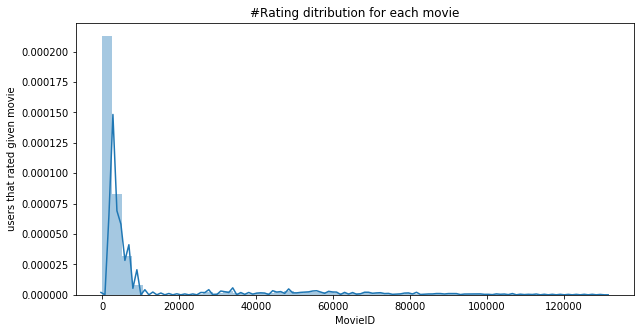

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('downloads/ml-20m/ratings.csv',sep = ',',usecols = ['userId','movieId','rating'])
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()
sparsity = round(1.0-len(df)/float(n_users*n_items),3)
print('The number unique of users is',n_users)
print('The number of unique items is',n_items)
print('The sparsity level is',sparsity*100,'%')

fig, ax = plt.subplots(figsize=(10,5))
fig = sns.distplot(df['movieId'])
ax.set_ylabel('users that rated given movie')
ax.set_xlabel('MovieID')
ax.set_title('#Rating ditribution for each movie')
plt.show()

## 3. Collaborative Filtering Algorithms ##

### 3.1 Item-based neighborhood-based collaborative filtering algorithm ###
#### i. Data Preprocessing ####
$\qquad$ Taking the above business concerns into considerations, we filter the dataset by setting the following constraints: we select users who have rated over 3000 movies and popular movies which were rated over 15000 times. After completing the filtering process, 56 active users and 252 movies remain in the dataset.

In [16]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import warnings 

%matplotlib inline
warnings.filterwarnings('ignore')

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7, progress_bar=False)
# for parallel computing the lambda function

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 7 workers


In [17]:
data = pd.read_csv('downloads/ml-20m/ratings.csv')
print("NaNs cells: ", data.isnull().values.sum())
data.drop("timestamp", inplace=True, axis=1)
popularMovie = data[['rating', 'movieId']].groupby("movieId").count()
popularMovie = popularMovie.loc[popularMovie['rating'] > 15000].index

popularUser = data[['rating', 'userId']].groupby("userId").count()
popularUser = popularUser.loc[popularUser['rating'] > 3000].index

print("the number of popular movies: ", len(popularMovie))
print("the number of active users: ", len(popularUser))

data = data.loc[ 
    (data['movieId'].isin(popularMovie)) & (data['userId'].isin(popularUser)) 
]

train, test = train_test_split(data, test_size=0.25)
train, valid = train_test_split(train, test_size=0.34)

'''
this is the same as 
train.pivot(
    index="movieId", 
    columns="userId",
    values="rating"
)
'''
movieCat = pd.api.types.CategoricalDtype(categories=sorted(train['movieId'].unique()))
userCat = pd.api.types.CategoricalDtype(categories=sorted(train['userId'].unique()))

rowIndex = train['movieId'].astype(movieCat).cat.codes
colIndex = train['userId'].astype(userCat).cat.codes
sparse_matrix = csr_matrix(
    (train["rating"], (rowIndex, colIndex)), 
    shape=(movieCat.categories.size, userCat.categories.size)
)

UserItemDF = pd.SparseDataFrame(
    sparse_matrix,
    index=movieCat.categories,
    columns=userCat.categories,
    default_fill_value=0
)

NaNs cells:  0
the number of popular movies:  252
the number of active users:  56


#### ii. Build item-item similarity matrix ####
1. Build iterm-user matrix (index: item, column: user)
2. Replace missing values ‘NAN’ with 0
3. Calculate cosine similarity between two movies 
4. K-nearest neighbors algorithm: Find out the top N closest neighbors as peer set by using cosine similarity as distance

In [18]:
model = NearestNeighbors(
    metric='cosine', 
    n_neighbors=20, 
    n_jobs=-1,
    algorithm='brute'
)

model.fit(UserItemDF)
dis, ind = model.kneighbors(return_distance=True)
'''
dis: distance in high dimension, smaller distance means high similarity
ind: Indices of the nearest points in the population matrix.
'''
# movieId = 1
dis[0], ind[0]
# key: movieId
# value: the row index in User-Item matrix
movieIdIndexMap = {movId: idx for idx, movId in enumerate(UserItemDF.index)}
showMovieIdIndexMap = list(movieIdIndexMap.items())

#### iii. Predict ratings of unrated films for selected users ####
$\qquad$ Predictions are calculated from the following equation: (prediction rating equals the sum of item average rating and normalized weighted neighbors ratings using cosine similarity)  
$$ p_{i,a} = \overline{r}_{a} + \frac{\sum_{u\in k}^{} (r_{u,i} - \overline{r}_{u})\times w_{a,u} }{\sum_{u\in k}^{} w_{a,u}}$$

In [19]:
def predict(movieId, userId, dis, ind, UserItemMatrix, returnAvg=False):
    movieIdIndexMap = {movId: idx for idx, movId in enumerate(UserItemMatrix.index)}
    movieIdIndexMapReversed = {idx: movId for idx, movId in enumerate(UserItemMatrix.index)}
    
    # since we used cosine similarity so the closest neighbor distance should be 1
    nonZeroUserIndex = np.nonzero(UserItemMatrix.loc[movieId])[0]
    sim = dis[ movieIdIndexMap[movieId] ]
    mu_movie = UserItemMatrix.loc[movieId]\
                             .iloc[nonZeroUserIndex]\
                             .mean()
    
    nonZeroMovieIndex = np.nonzero(UserItemMatrix.iloc[ind[ movieIdIndexMap[movieId] ]].loc[:, userId])[0]
    denom = np.sum( abs(sim[nonZeroMovieIndex]) )
    nom = (UserItemMatrix.iloc[ind[ movieIdIndexMap[movieId] ]]
                     .loc[:, userId]\
                     .iloc[nonZeroMovieIndex]
           - UserItemMatrix.iloc[ind[ movieIdIndexMap[movieId] ]]\
                           .iloc[nonZeroMovieIndex]
                           .to_dense()\
                           .replace({0: np.nan})\
                           .mean(axis=1, skipna=True)
    ).values

    if len(nonZeroMovieIndex) == 0:
        prediction = mu_movie
    else:
        prediction = mu_movie + np.sum(nom * sim[nonZeroMovieIndex]) / denom

    if returnAvg:
        return prediction, mu_movie
    else:
        return prediction

    
def func(s):
    return predict(
        movieId=s['movieId'],
        userId=s['userId'], 
        dis=dis, ind=ind, 
        UserItemMatrix=UserItemDF
    )

train['predict'] = train.parallel_apply(func, axis=1)
test['predict'] = test.parallel_apply(func, axis=1)

### 3.2 Model-based collaborative filtering algorithm ###
$\qquad$ Model-based collaborative filtering uses the matrix factorization algorithm to represent users' preference with vectors in lower dimensions. ALS model is one of the algorithms that decomposes user-item matrix into low rank user matrix and item matrix such that users and products are described by a small set of latent factors that can be used to predict missing entries. ALS model is good at dealing with sparse dataset, which is suitable for our MovieLens dataset. 


In [9]:
import os
import pyspark
from pyspark import SparkFiles
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import rand, col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

seed = 100
sc = SparkContext()
filePath = "../ml-20m/ratings.csv"


# read dataset into spark RDD
sc.addFile(filePath)
sqlContext = SQLContext(sc)
df = sqlContext.read.csv(
    SparkFiles.get("ratings.csv"), 
    header=True, 
    inferSchema=True
)

sqlContext.registerDataFrameAsTable(df, "df")
df = sqlContext.sql('''
    SELECT 
        userId AS user, 
        movieId AS item,
        rating
    FROM df
''')


# adding uniform random numbers for train/validation/test set
df = df.withColumn('TrainTest', rand(seed=seed))
dftrain = df.where(col('TrainTest') < 0.75).drop(*["TrainTest"])
dftest = df.where(col('TrainTest') >= 0.75).drop(*["TrainTest"])

In [ ]:
rmse_list = []
mae_list = []

ranks = [20]
regs = [0.05]
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")
mae = RegressionEvaluator(metricName="mae", labelCol="rating")

for rank in ranks:
    for reg in regs:
        als = ALS(rank = rank,regParam = reg, nonnegative=True, checkpointInterval=3, coldStartStrategy="drop")
        
        paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [rank]) \
            .addGrid(als.regParam, [reg])\
            .build()

        tvs = TrainValidationSplit(
            estimator=als,
            evaluator=rmse,
            estimatorParamMaps=paramGrid,
            seed=seed,
            trainRatio=0.66, # this ratio makes train:0.5 valid:0.25 and test:0.25
            parallelism=6,
        )

        model = tvs.fit(dftrain)
        testPred = model.transform(dftest)
        error1 = rmse.evaluate(testPred)
        error2 = mae.evaluate(testPred)
        print('{} latent factors and regularization = {}: validation RMSE is {}，MAE is {}'.format(rank, reg, error1,error2))
        rmse_list.append(error1)
        mae_list.append(error2)

### 3. Model Evaluation Methods ###
#### i. Cross-validation setup####
$\qquad $ We use the train-validation-test setup to tune hyper parameters and evaluate the model performance. The ratio is 50% training, 25% validation, and 25% testing. The hyper parameters are tuned on the validation set, while the final result is reported on the test set
#### ii. Accuracy on training and test data ####
$\qquad$ For the evaluation of accuracy, we use the simplest baseline model. We predict the mean rating over the entire data set and calculate models’ accuracy using RMSE as the primary metric and MAE as the secondary metric. Then, we use our collaborative filtering algorithm models to make predictions and calculate error to compare with the baseline model. The error on the training set is relatively smaller.
#### iii. Coverage on training and test data ####
$\qquad$ We can use the catalog coverage, which is the ratio of recommended user-item pairs over the total number of potential pairs. To calculate the coverage, we take the recommendation for the test users and diveded by the total number of movies to see how large a portion of movies are covered in our recommendation

### 4. Model Performance ###
$\qquad$ We implement the root mean square error (RMSE) and mean absolute error (MAE) measurements in the neighborhood-based model and model-based model to evaluate their performance. In order to achieve relatively better evaluation metrics, we’ve performed grid search to tune the hyperparameters in each model.

In [7]:
ratingAvg = data['rating'].mean()
test['baseline'] = ratingAvg
print("Baseline Model (Rating Average) Performance on Test Set")
print("RMSE: ", mean_squared_error(test['rating'], test['baseline']))
print("MAE: ", mean_absolute_error(test['rating'], test['baseline']))

Baseline Model (Rating Average) Performance on Test Set
RMSE:  0.9923954429054456
MAE:  0.8110607948032077


### 4.1 Performance of item-based neighborhood-based collaborative filtering algorithm
$\qquad$ As we vary the size of the neighbourhood set size as 10, 20, and 30, the resulting RMSE are decreasing:  0.8196 , 0.6847, 0.6403. Observing the resulte, it could be conclude that the increase number in the neighbourhood size leads to the increase in the model performance. Therefore, the neighbourhood set size affects the result of the prediction for the item-based neighborhood-based model. 

In [20]:
modelOne = NearestNeighbors(
    metric='cosine', 
    n_neighbors=30, 
    n_jobs=-1,
    algorithm='brute'
)
modelOne.fit(UserItemDF)
disOne, indOne = modelOne.kneighbors(return_distance=True)


modelTwo = NearestNeighbors(
    metric='cosine', 
    n_neighbors=20, 
    n_jobs=-1,
    algorithm='brute'
)
modelTwo.fit(UserItemDF)
disTwo, indTwo = modelTwo.kneighbors(return_distance=True)


modelThree = NearestNeighbors(
    metric='cosine', 
    n_neighbors=10, 
    n_jobs=-1,
    algorithm='brute'
)
modelThree.fit(UserItemDF)
disThree, indThree = modelThree.kneighbors(return_distance=True)

def func(s, dis, ind, UserItemMatrix):
    return predict(
        movieId=s['movieId'],
        userId=s['userId'], 
        dis=dis, ind=ind, 
        UserItemMatrix=UserItemMatrix
    )

train['predictOne'] = train.parallel_apply(
    func, axis=1, dis=disOne, ind=indOne, UserItemMatrix=UserItemDF
)
train['predictTwo'] = train.parallel_apply(
    func, axis=1, dis=disTwo, ind=indTwo, UserItemMatrix=UserItemDF
)
train['predictThree'] = train.parallel_apply(
    func, axis=1, dis=disThree, ind=indThree, UserItemMatrix=UserItemDF
)

valid['predictOne'] = valid.parallel_apply(
    func, axis=1, dis=disOne, ind=indOne, UserItemMatrix=UserItemDF
)

valid['predictTwo'] = valid.parallel_apply(
    func, axis=1, dis=disTwo, ind=indTwo, UserItemMatrix=UserItemDF
)

valid['predictThree'] = valid.parallel_apply(
    func, axis=1, dis=disThree, ind=indThree, UserItemMatrix=UserItemDF
)


model performance on training set
RMSE:  0.5447087561317404
MAE:  0.5684216511917545


model performance on validation set
RMSE:  0.6648909427320595
MAE:  0.6341068745080062
model performance on testing set
RMSE:  0.6900512767615933
MAE:  0.6343663877506326


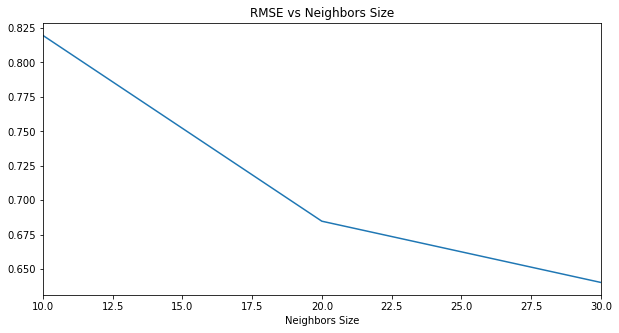

In [11]:
print("model performance on training set")
print('RMSE: ', mean_squared_error(train['rating'], train['predictOne']))
print('MAE: ', mean_absolute_error(train['rating'], train['predictOne']))

print("\n\nmodel performance on validation set")
print('RMSE: ', mean_squared_error(valid['rating'], valid['predictOne']))
print('MAE: ', mean_absolute_error(valid['rating'], valid['predictOne']))

test['predict'] = test.parallel_apply(
    func, axis=1, dis=disOne, ind=indOne, UserItemMatrix=UserItemDF
)
print("model performance on testing set")
print('RMSE: ', mean_squared_error(test['rating'], test['predict']))
print('MAE: ', mean_absolute_error(test['rating'], test['predict']))

RMSE = pd.DataFrame([0.64033783953412, 0.6847783249081223, 0.8196170756782438], columns=["RMSE"])
neighborSize = pd.Series([30, 20, 10], name="Neighbors Size")
RMSE.index = neighborSize
RMSE["RMSE"].plot(
    figsize=(10, 5),
    title="RMSE vs Neighbors Size"
)
plt.xlabel = "Neighbors Size"
plt.ylabel = "RMSE"

### 4.2 Performance of model-based collaborative filtering algorithm
$\qquad$ The number of latent dimensions used in the matrix factorization impacts our result of prediction. Increasing the number of latent dimensions would improve the predictions until the number is too high that the model tends to overfit. We vary the number of latent dimensions from the following: 5, 10, 20. In addition, since ALS uses L2 regularization, the regularization parameter used in the als model also impacts the prediction result. Increasing the regularization parameter would avoid overfitting but we also want to limit the parameter that it won’t cause a great increase in bias in the model. We vary the parameter of regularization as 0.05, 0.01, 1. We tuned both parameters using a random sample size that is 0.1% of the complete data set. As we can see, under the same rank, smaller the regularization results in a lower error. 

In [25]:
df = df.sample(False,0.001)
dftrain = df.where(col('TrainTest') < 0.75).drop(*["TrainTest"])
dftest = df.where(col('TrainTest') >= 0.75).drop(*["TrainTest"])
rmse_list = []
mae_list = []
ranks = [5,10,20]
regs = [0.05, 0.01, 1]
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")
mae = RegressionEvaluator(metricName="mae", labelCol="rating")

for rank in ranks:
    for reg in regs:
        als = ALS(rank = rank,regParam = reg, nonnegative=True, checkpointInterval=3, coldStartStrategy="drop")
        
        paramGrid = ParamGridBuilder()\
            .addGrid(als.rank, [rank]) \
            .addGrid(als.regParam, [reg])\
            .build()

        tvs = TrainValidationSplit(
            estimator=als,
            evaluator=rmse,
            estimatorParamMaps=paramGrid,
            seed=seed,
            trainRatio=0.66, # this ratio makes train:0.5 valid:0.25 and test:0.25
            parallelism=6,
        )

        model = tvs.fit(dftrain)
        testPred = model.transform(dftest)
        error1 = rmse.evaluate(testPred)
        error2 = mae.evaluate(testPred)
        print('{} latent factors and regularization = {}: validation RMSE is {}，MAE is {}'.format(rank, reg, error1,error2))
        rmse_list.append(error1)
        mae_list.append(error2)
        

5 latent factors and regularization = 0.05: validation RMSE is 2.3927053526050885，MAE is 2.0357645742165302
5 latent factors and regularization = 0.01: validation RMSE is 3.153087698273621，MAE is 2.461251913190988
5 latent factors and regularization = 1: validation RMSE is 2.390377978164582，MAE is 2.1332545101938156
10 latent factors and regularization = 0.05: validation RMSE is 2.278484792001456，MAE is 1.9784225488558072
10 latent factors and regularization = 0.01: validation RMSE is 2.3799398682000077，MAE is 2.034882838008221
10 latent factors and regularization = 1: validation RMSE is 2.4591924100601434，MAE is 2.226668984776886
20 latent factors and regularization = 0.05: validation RMSE is 2.1784833334426104，MAE is 1.9038581722401853
20 latent factors and regularization = 0.01: validation RMSE is 2.1662722619543415，MAE is 1.8754354239572761
20 latent factors and regularization = 1: validation RMSE is 2.462927117639181，MAE is 2.2415006862337195


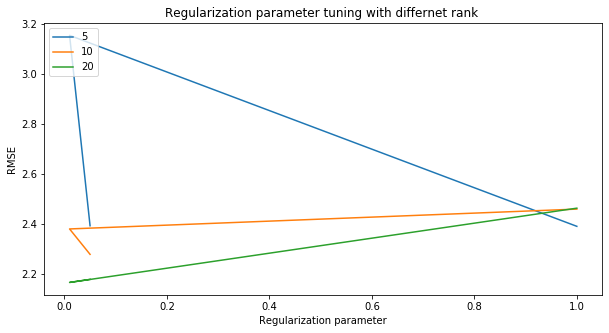

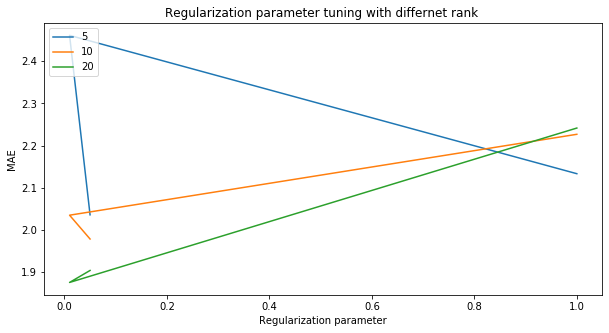

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(regs, rmse_list[0:3],regs,rmse_list[3:6], regs,rmse_list[6:9])
ax.set_ylabel('RMSE')
ax.set_xlabel('Regularization parameter')
ax.set_title('Regularization parameter tuning with differnet rank ')
plt.legend(['5', '10', '20'], loc = 'upper left', frameon=True)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(regs, mae_list[0:3],regs,mae_list[3:6], regs,mae_list[6:9])
ax.set_ylabel('MAE')
ax.set_xlabel('Regularization parameter')
ax.set_title('Regularization parameter tuning with differnet rank ')
plt.legend(['5', '10', '20'], loc = 'upper left', frameon=True)

### 4.2 Model size variation
$\qquad$ For different sample size, it is reasonable for models to have different performance. In order to understand how the evaluation metric change with the training set size, we modified the training set size as 1%, 10%,  30%, 50%  of the entire dataset size. According to our experiments, the overall accuracy changes over different training set sizes: the model with larger training set size has a higher accuracy (smaller RMSE) but requires a longer training time.

In [ ]:
import time
for splitSize in [0.001, 0.01, 0.1, 0.3, 0.5]:
    start = time.time()
    dftrain = df.where(col('TrainTest') < splitSize).drop(*["TrainTest"])
    trainSize = dftrain.count()
    
    
    dftest = df.where(col('TrainTest') > splitSize).drop(*["TrainTest"])
    testSize = dftest.count()
    
    
    als = ALS(nonnegative=True, checkpointInterval=3, coldStartStrategy="drop")
    paramGrid = ParamGridBuilder() \
        .addGrid(als.rank, [5]) \
        .addGrid(als.regParam, [0.1]) \
        .build()

    
    tvs = TrainValidationSplit(
        estimator=als,
        estimatorParamMaps=paramGrid,
        evaluator=rmse,
        seed=seed,
        trainRatio=0.66, # this ratio makes train:0.5 valid:0.25 and test:0.25
        parallelism=3
    )
    
    
    model = tvs.fit(dftrain)
    model_path = os.getcwd() + '/training_models/ALS_splitSize-' + str(splitSize)
    model.save(model_path)
    testPred = model.transform(dftest)
    trainPred = model.transform(dftrain)
    
    end = time.time()
    
    result[splitSize] = {
        "time": end-start, 
        "rmseTrain": rmse.evaluate(trainPred),
        "rmseTest": rmse.evaluate(testPred), 
        "maeTrain": mae.evaluate(trainPred),
        "maeTest": mae.evaluate(testPred),
        "trainSize": trainSize,
        "testSize": testSize
    }
    
pd.DataFrame(result).T['time'].plot(
    figsize=(15, 8),
    title="Running Time vs Training Set Size"
)
plt.xlabel('Training Set Size (percentage)')
plt.ylabel('Running Time (seconds)')

pd.DataFrame(result).T['rmseTest'].plot(
    figsize=(15, 8),
    title="RMSE (testing set) vs Training Set Size"
)
plt.xlabel("Training Set Size (percentage)")
plt.ylabel("RMSE")

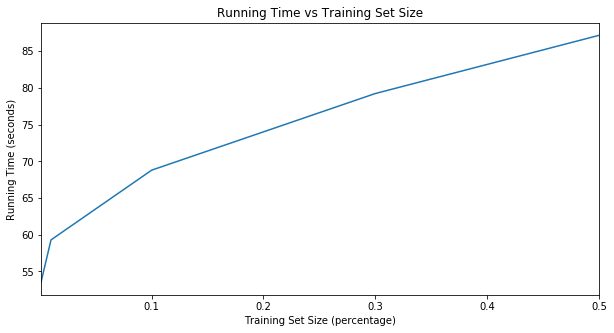

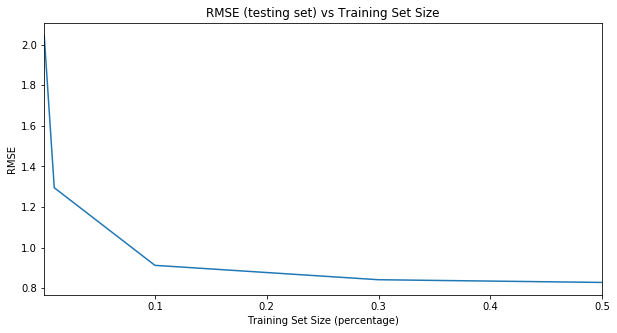

In [18]:
import pandas as pd
import pickle
import matplotlib.pylab as plt
%matplotlib inline

result = pickle.load( open( "../result.pkl", "rb" ) )

pd.DataFrame(result).T['time'].plot(
    figsize=(10, 5),
    title="Running Time vs Training Set Size"
)
plt.xlabel('Training Set Size (percentage)')
plt.ylabel('Running Time (seconds)')
plt.show()

pd.DataFrame(result).T['rmseTest'].plot(
    figsize=(10, 5),
    title="RMSE (testing set) vs Training Set Size"
)
plt.xlabel("Training Set Size (percentage)")
plt.ylabel("RMSE")
plt.show()

### 5. Concolusion
#### i. Result ####
$\qquad$ After tuning the hyperparameters under each case, we conclude our models by choosing the best hyperparameters that minimize evaluation metrics. In the item-based memory-based model, the final RMSE is 0.6900512767615933 and the MAE is: 0.6343663877506326. Comparing with the baseline RMSE: 1.0519832166584029 and baseline MAE: 0.840690943200106, it is lower by 34% and 24%. Under the model-based model-based model, the final RMSE is 0.7953830458336725,  and MAE is 0.6172952042333186. Comparing with the baseline RMSE and baseline MAE, it is lower by 25% and 26%. Therefore, we meet our hypothetical objectives by outperforming the baseline model for a great amount.
#### ii. Limitations ####
$\qquad$ However, there are some business concerns that need to be taken into consideration when making predictions and recommendations based on the MovieLens dataset. Some users have rated many more films and the ratings range over 10 years. Considering that users’ preferences change over time, more recent ratings would be more important for predictions compared with the previous ones. Therefore, bias may exist if the model gives each rating the same weight. 
#### iii. Potential Improvement ####
$\qquad$ An improved model could be a model that also take timestamp as consideration. In order to take user preferences change into account, we can assign a larger weight on  users’ recent rating and a smaller weight on user’s past rating. We can give a higher weight on user’s recent rating and a lower weight on user’s past ratings based on the timestamp of the ratings. Furthermore, to increase the coverage, we can give higher weight on movies that are rated by few people so we can cover not only the popular movies, thus add some novelty to the recommendation. Beyond the models, we have also noted that the data provides the info on the movies' genres. It may also be useful to take that into account and build a memory-based model to see if that helps with better prediction.